# into my eyes

In [1]:
from collections import defaultdict
from io import StringIO
from pathlib import Path
from tqdm import tqdm

from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns

import openpyxl
from captum.attr import visualization
from tqdm import tqdm


In [2]:
from erisk import metrics

In [3]:
def rescale(v, method):
    a = np.array(v)
    match method.lower():
        case "prob":
            a = (a - a.min()) / (a.max() - a.min())
        case "softmax":
            a = np.exp(a) / sum(np.exp(a))
        case "std":
            a = (a - a.mean()) / (a.std())
        case "relu":
            a = np.maximum(0, a)
        case _:
            print(f'"{rescale}" is ignored because is not a supported rescale method')
    return a

def md_rescale(A, method):
    return [rescale(a, method) for a in A]

In [4]:
def plot_vdr(tokens_list: list[list], scores_list: list[list]):
    vis_data_records = list()
    for tokens, scores in zip(tokens_list, scores_list):
        a = np.array(scores)
        vdr = visualization.VisualizationDataRecord(
            pred_prob=0.68,  # (Predicted Label)
            pred_class="depress",  # Predicted Label
            word_attributions=a,
            true_class="depress",  # True Label, ground-truth label of the input
            attr_class="*",  # Attribution Label, the input
            attr_score=a.sum(),  # Attribution Score, the sum of IG accross the whole tokens
            raw_input_ids=tokens,  # the list of tokens
            convergence_score=0,  # the difference between approximated and true integrated gradients
        )
        vis_data_records.append(vdr)
    visualization.visualize_text(vis_data_records)


## datasets

Loading and mergin dataset

In [5]:
data_text = ""

for filename in sorted(["ds", "ts_hs", "ts_ht"]):
    with open(
        Path("datasets", "task_0", f"{filename}.tsv"), "rt", encoding="utf8"
    ) as f:
        data_text += f.read()

df = pd.read_csv(StringIO(data_text), sep="\t")
df = df.drop_duplicates().reset_index(names="old_idx").reset_index(names="new_idx")

splitting the dataset in training and testing (following previous works)

In [6]:
# lookup = df.set_index("old_idx")["new_idx"]
# pth = Path("datasets", "task_0", "train_test_splitting.json")
# idx = json.load(open(pth, "rt"))
# idx = {k: [lookup[i] for i in lst if i in lookup] for k, lst in idx.items()}

In [7]:
# x, y = df["raw_text"], df["label"]
# x_train, x_test = x.loc[idx["train"]], x.loc[idx["test"]]
# y_train, y_test = y.loc[idx["train"]].astype(int), y.loc[idx["test"]].astype(int)

loading psycologist highlights

In [8]:
wb = openpyxl.load_workbook('datasets/task_0/Testset.xlsx')
sheet = wb.active

In [9]:
yellow, no_highlight = list(), list()

In [10]:
for row in range(2, 1105):
    uid = sheet[f"A{row}"].value
    text = sheet[f"B{row}"].value
    pattern = sheet[f"C{row}"].value
    if pattern is not None and pattern.strip():
        yellow.append((uid, text, pattern))
    else:
        no_highlight.append((uid, text))

In [11]:
df_yellow = pd.DataFrame(yellow, columns=["excel_idx", "text", "pattern"])
df_val = pd.merge(df, df_yellow, left_on="raw_text", right_on="text")
df = df.loc[~df.new_idx.isin(df_val.new_idx)] # remove val

In [12]:
X, y = df["pp_text"], df.label.astype(int)

pattern borders

In [13]:
import re
resp = r"\, |\. |\; |\: |\! |\? |\.|  | \<|\> |I "

In [14]:
pattern_boundaries = defaultdict(list)
for i, row in df_yellow.iterrows():
    text_bites = [
        v.strip().strip() for v in re.split(resp, row["pattern"]) if v.strip().strip()
    ]
    for bit in text_bites:
        istart = row["text"].lower().find(bit.lower())
        if istart != -1:
            istop = istart + len(bit)
            pattern_boundaries[row.excel_idx].append((istart, istop))
        # else:
        #     print(bit)
        #     print(row["text"])


In [15]:
for k, l in pattern_boundaries.items():
    i = 0
    while i < len(l) - 1:
        if l[i + 1][0] - l[i][1] < 7:
            l[i] = (l[i][0], l[i + 1][1])
            del l[i + 1]
        else:
            i += 1
    pattern_boundaries[k] = l


## models

### human

In [16]:
human_tokens = df_yellow.set_index("excel_idx").loc[35].text.lower().split()[:-1]
human_scores = [ 0.4 if 7 <= i else 0.0 for i in range(len(human_tokens))]

In [17]:
plot_vdr([human_tokens], [human_scores])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
depress,depress (0.68),*,4.80,it comes back to that thing where i feel like i hurt people more than i could give them.


### born tf idf

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from bornrule import BornClassifier

In [19]:
vect = TfidfVectorizer()
tfidf_mx = vect.fit_transform(X).toarray()
words = vect.get_feature_names_out()

In [20]:
W = words.shape[0]

In [21]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    tfidf_mx,
    y,
    list(range(len(y))),
    test_size=0.2,
    random_state=42,
    stratify=y,
)

In [22]:
amplitude = 0.5 #amplitude
balance = 1 #balance
entropy = 1 #entropy

In [23]:
born = BornClassifier(a=amplitude, b=balance, h=entropy)
born.fit(X=X_train, y=y_train)

BornClassifier(b=1, h=1)

In [24]:
y_hat = born.predict(X_test)
metrics(y_hat, y_test)

F1: 0.78
Precision: 0.66
Recall: 0.95
Accuracy: 0.74


In [25]:
born.classes_

array([0, 1])

In [26]:
weights = born.explain()[:,1]
scores = sorted(list(zip(words, weights)), key = lambda x : x[-1], reverse=True)
kwscores = defaultdict(float, scores)

In [27]:
kwscores

defaultdict(float,
            {'feel': 0.04792751753743948,
             'depression': 0.03301031147638017,
             'hate': 0.030198302955135623,
             'bad': 0.029885460682954827,
             'depressed': 0.023929994609127387,
             'anxiety': 0.023340959735657404,
             'awful': 0.02281930656317629,
             'excuse': 0.02189850587119861,
             'diagnosed': 0.021816289926095578,
             'ill': 0.021787282396561726,
             'black': 0.021132474257161225,
             'ugh': 0.01907263384624204,
             'sick': 0.01875791022612031,
             'mood': 0.018708149773126875,
             'crying': 0.018502090393258157,
             'fatty': 0.01821993714004599,
             'nasty': 0.018103343026241336,
             'anytime': 0.018041119566757392,
             'disorder': 0.01794863249550751,
             'antidepressants': 0.017052799226276623,
             'lonely': 0.016806628524841768,
             'feeling': 0.0168043252069995

global ranking

In [28]:
groups = ("TP", "FP", "FN", "TN")
y_group = []
for i, v in enumerate(zip(y_hat, y_test)):
    match v:
        case (0, 0):
            y_group.append("TN")
        case (1, 1):
            y_group.append("TP")
        case (0, 1):
            y_group.append("FN")
        case (1, 0):
            y_group.append("FP")
        case _:
            raise ValueError("!")

In [29]:
test_corpus = [
    " ".join(X.iloc[idx_test].reset_index(drop=True).loc[pd.Series(y_group) == g])
    for g in groups
]


In [30]:
tfidf_corpus = vect.transform(test_corpus).toarray()

In [31]:
global_explain = [born.explain(a.reshape(1, -1)) for a in tfidf_corpus]


In [32]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

In [33]:
charts = {
    g: [
        word
        for word in sorted(
            zip(words, global_explain[i]), key=lambda x: x[-1][-1], reverse=True
        )
        if word[0] not in english_stopwords
    ]
    for i, g in enumerate(groups)
}


In [34]:
for g, tier in charts.items():
    print("+" * 5, g, "+" * 5)
    for k, v in tier[:]:
        print(k)

+++++ TP +++++
feel
depression
bad
hate
anxiety
depressed
feeling
awful
black
pain
diagnosed
sick
excuse
mood
ill
mental
people
like
disorder
therapist
doctor
weight
sad
crying
younger
terrible
longer
poor
boyfriend
ugh
medication
sucks
worse
little
understand
late
panic
crazy
illness
symptoms
lonely
suicidal
meds
talked
therapy
trying
things
relationship
sleep
painful
cope
talk
partner
diagnosis
badly
really
miserable
cry
person
minute
sale
pills
someone
physical
wanting
nasty
disappointed
psychiatrist
antidepressants
something
dramatic
mg
leave
angry
worth
happened
drinks
tight
depressive
impossible
dirty
sometimes
lost
helps
physically
ocd
parents
exhausted
anything
least
friends
slaves
headache
motivation
feelings
weeks
joints
severe
anger
sober
relationships
going
makes
cheating
apologies
confidence
completely
healthy
anytime
freshman
seconds
patients
afraid
self
want
horrible
hell
mixed
experience
energy
bpd
asexual
psychologist
dae
serotonin
taking
since
take
alcohol
comfortable

let's see locally

In [35]:
yellow_born = vect.transform(df_val.pp_text).toarray()

In [36]:
born_tokens, born_scores, born_idx = list(), list(), list()
for idx, v in tqdm(enumerate(yellow_born)):
    sample = v.reshape((1, W))
    weights = born.explain(sample)[:, 1]
    scores = sorted(list(zip(words, weights)), key=lambda x: x[-1], reverse=True)
    kwscores = defaultdict(float, scores)

    tokens = df_val.loc[idx, "pp_text"].split()
    scores = np.array([kwscores[w] for w in tokens])

    born_tokens.append(tokens)
    born_scores.append(scores)
    born_idx.append(df_val.loc[idx].excel_idx)

161it [00:08, 17.97it/s]


In [37]:
born_scores = md_rescale(born_scores, "prob")

In [38]:
plot_vdr(born_tokens[:30], born_scores[:30])

### RoBERTa

In [39]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050'

In [40]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

In [41]:
tokenizer_hf = AutoTokenizer.from_pretrained("ShreyaR/finetuned-roberta-depression")
model = AutoModelForSequenceClassification.from_pretrained("ranieri-unimi/test-trainer")

In [42]:
rob_scores, rob_tokens, rob_idx= list(), list(), list()
for idx, text in tqdm(df_val.raw_text.items()):
    input_ids = tokenizer_hf.encode(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(
        input_ids,
        output_attentions=True,
        # attention_mask=attention_mask,
    )
    attention_weights = outputs[-1]
    attention_norms = attention_weights[-1][0, :, :, :].norm(dim=0)
    scores = attention_norms[0, 1:-1].cpu().detach().numpy()
    tokens = [tokenizer_hf.decode(e).lower().strip() for e in input_ids[0, 1:-1]]

    rob_scores.append(scores)
    rob_tokens.append(tokens)
    rob_idx.append(df_val.loc[idx].excel_idx)

161it [01:06,  2.41it/s]


In [43]:
rob_scores = md_rescale(rob_scores, "std")
rob_scores = md_rescale(rob_scores, "relu")
rob_scores = md_rescale(rob_scores, "prob")
# rob_scores = md_rescale(rob_scores, "softmax")
# rob_scores = md_rescale(rob_scores, "softmax")
# rob_scores = md_rescale(rob_scores, "softmax")
# very aggressive

In [44]:
plot_vdr(rob_tokens[:30], rob_scores[:30])

### spike

moving average

In [45]:
N = 5
rolling_weights = np.ones(N) / N  # uniform
rolling_weights = np.array([1, 3, 6, 3, 1]) / 14


In [46]:
# sns.lineplot(raw_scores)
# sns.lineplot(smooth_scores)

In [47]:
born_matches = defaultdict(lambda : False)

for raw_scores, tokens, excel_idx in zip(born_scores, born_tokens, born_idx):
    smooth_scores = np.convolve(raw_scores, rolling_weights, mode="same")
    eigen_word = tokens[smooth_scores.argmax()]
    text = df_yellow.set_index("excel_idx").loc[excel_idx, "text"]
    # eigen_idx = text.find(eigen_word)
    eigen_indices = [m.start() for m in re.finditer(eigen_word, text)]

    has_matched = False
    for start, end in pattern_boundaries[excel_idx]:
        for eigen_idx in eigen_indices:
            if start < eigen_idx < end:
                born_matches[excel_idx] = True
                continue
        
sum(born_matches.values()) / len(born_idx)  

0.6459627329192547

In [48]:
rob_matches = defaultdict(lambda : False)

for raw_scores, tokens, excel_idx in zip(rob_scores, rob_tokens, rob_idx):
    smooth_scores = np.convolve(raw_scores, rolling_weights, mode="same")
    eigen_word = tokens[smooth_scores.argmax()]
    text = df_yellow.set_index("excel_idx").loc[excel_idx, "text"]
    # eigen_idx = text.find(eigen_word)
    eigen_indices = [m.start() for m in re.finditer(eigen_word, text)]

    has_matched = False
    for start, end in pattern_boundaries[excel_idx]:
        for eigen_idx in eigen_indices:
            if start < eigen_idx < end:
                rob_matches[excel_idx] = True
                continue
        
sum(rob_matches.values()) / len(rob_idx)

0.39751552795031053

In [49]:
w = [stats.wasserstein_distance(u ,v) for u,v in zip(rob_scores, born_scores)]

In [50]:
from matplotlib import pyplot as plt
sns.set_context("paper")
sns.set_style("darkgrid")

[Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, ''),
 [Text(0, 0.0, ''),
  Text(0, 5.0, ''),
  Text(0, 10.0, ''),
  Text(0, 15.0, ''),
  Text(0, 20.0, ''),
  Text(0, 25.0, ''),
  Text(0, 30.0, '')]]

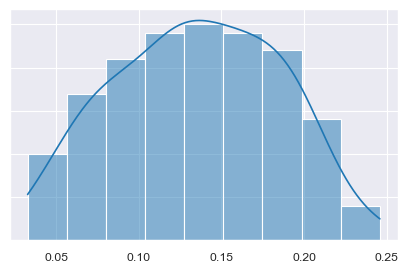

In [51]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(w, kde=True, ax=ax).set(
    xlabel="",
    ylabel="",
    title=None,
    yticklabels=[],
)


In [52]:
np.mean(w), np.std(w)

(0.13483597647661869, 0.04928048824830491)

### GMM

In [53]:
from sklearn.cluster import MeanShift

In [54]:
idx = 19
sample_score = born_scores[idx]
sample_token = born_tokens[idx]
print(" ".join(sample_token))

these are things that i m working on distractions and realising you just have to keep on going the world doesn t stop for you so that you can curl up into a corner and cry set yourself little goals and then take steps to achieve them give yourself a purpose learning coping mechanisms so that you can roll with the punches also helps


In [55]:
scatter_spectre = [
    (x, y)
    for x, v in enumerate(sample_score)
    for y in range(-int(v * 8), int(v * 8) + 1)
]
ms = MeanShift(max_iter=10000)
clustering = ms.fit(scatter_spectre)
ms.cluster_centers_


array([[39.27777778,  0.        ],
       [10.51923077,  0.        ],
       [53.08510638,  0.        ]])

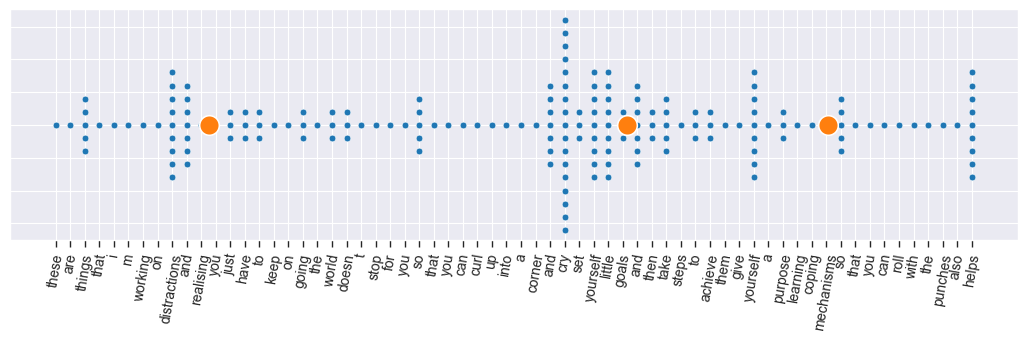

In [56]:
x_spectre, y_spectre = zip(*scatter_spectre)
x_centers, y_centers = zip(*ms.cluster_centers_)
fig, ax = plt.subplots(figsize=(13, 3))

plt.xticks([i for i in range(len(sample_token))])
sns.scatterplot(x=x_spectre, y=y_spectre, ax=ax)
sns.scatterplot(x=x_centers, y=y_centers, s=200, ax=ax)

plt.xticks(rotation=80)
ax.set(
    xticklabels=sample_token,
    yticklabels=[],
)
ax.tick_params(bottom=True, left=False, labelsize=10)


In [57]:
0/0

ZeroDivisionError: division by zero

In [ ]:
mu, sigma = 20, 8
mu2, sigma2 = 10, 4
X1 = np.random.normal(mu, sigma, N)
X2 = np.random.normal(mu2, sigma2, N)
X = np.concatenate([X1, X2])
sns.kdeplot(x=X)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
sample_token = "One of the most important things you could realize is that I found me alone".split()
N = len(sample_token)
x_spectre = [i for i in range(N)]
plt.xticks(x_spectre)

mu, sigma = 4, 2
mu2, sigma2 = 11, 1
X1 = np.random.normal(mu, sigma, 500)
X2 = np.random.normal(mu2, sigma2, 500)
X = np.concatenate([X1, X2])
sns.histplot(x=[e for e in X if 0 <= e < N])

mu, sigma = 8, 2
mu2, sigma2 = 13, 1
X1 = np.random.normal(mu, sigma, 500)
X2 = np.random.normal(mu2, sigma2, 500)
X = np.concatenate([X1, X2])
sns.histplot(x=[e for e in X if 0 <= e < N])

X = [N - 4.5, N - 0.5] * 8  # np.random.uniform(N-4.3, N, 20)
sns.histplot(x=[x for x in X if 0 <= x < N], bins=1)

plt.xticks(rotation=60)
ax.set(
    xticklabels=sample_token,
    yticklabels=[],
)
ax.tick_params(bottom=True, left=False)
